# New LSTM Oslo PM2.5

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras import layers

# Load data
df = pd.read_excel("PM25OsloTS.xlsx")  

 
# Temporal feature processing
# For example, convert time features to date time format and extract year, month, and day information
df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y')
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df = df.sort_values(by='Time')  # Sort DataFrame by time

 
print(df.head(10))

# Extract features and target variable
X = df[["TV", "Tmean", "HDD", "VP", "WS", "WG", "meanRH", "SD", "PP", "Year", "Month","Day"]]
y = df["PM25"]


# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define time steps
time_steps = 1  # You can adjust this as needed

# Generate time series data
X_time_series = []
y_time_series = []

for i in range(len(X_scaled) - time_steps):
    X_time_series.append(X_scaled[i:(i + time_steps), :])
    y_time_series.append(y[i + time_steps - 1])

X_time_series = np.concatenate(X_time_series, axis=0)
y_time_series = np.array(y_time_series)

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_time_series, y_time_series, test_size=0.2, random_state=42)

# Define LSTM model
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=512, step=16),
                                       activation='relu',
                                       return_sequences=True,
                                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                       input_shape=self.input_shape))
        model.add(tf.keras.layers.Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.4, 0.6, 0.8])))

        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(tf.keras.layers.LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=16),
                                           activation='relu',
                                           return_sequences=True))
            model.add(tf.keras.layers.Dropout(rate=hp.Choice(f'dropout_rate_{i}', values=[0.2, 0.4, 0.6, 0.8])))

        model.add(tf.keras.layers.LSTM(units=hp.Int('units_last', min_value=32, max_value=512, step=16),
                                       activation='relu',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(tf.keras.layers.Dropout(rate=hp.Choice('dropout_rate_last', values=[0.2, 0.4, 0.6, 0.8])))

        model.add(tf.keras.layers.Dense(1))
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse')
        return model

# Perform hyperparameter tuning
hypermodel = MyHyperModel(input_shape=(1, X_train.shape[1]))
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='PM25_prediction')

tuner.search(X_train.reshape((-1, 1, X_train.shape[1])), y_train, epochs=50, validation_split=0.2)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build final model with best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

# Train the model
history = final_model.fit(X_train.reshape((-1, 1, X_train.shape[1])), y_train, epochs=50, validation_split=0.2)




Reloading Tuner from my_dir\PM25_prediction\tuner0.json


C:\Users\congc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 1.6611 - val_loss: 1.3938
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3580 - val_loss: 1.3579
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3151 - val_loss: 1.3278
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1356 - val_loss: 1.3021
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2292 - val_loss: 1.2800
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1857 - val_loss: 1.2600
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0534 - val_loss: 1.2399
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0861 - val_loss: 1.2170
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1145 - val_loss: 1.1920
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.2811 - val_loss: 1.1659
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.2983 - val_loss: 1.1496
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.

In [12]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# List optimal hyperparameters
print("Optimal Hyperparameters:")
print(f"units: {best_hps.get('units')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"num_layers: {best_hps.get('num_layers')}")

for i in range(best_hps.get('num_layers')):
    print(f"units_{i}: {best_hps.get(f'units_{i}')}")
    print(f"dropout_rate_{i}: {best_hps.get(f'dropout_rate_{i}')}")

print(f"units_last: {best_hps.get('units_last')}")
print(f"dropout_rate_last: {best_hps.get('dropout_rate_last')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")


Optimal Hyperparameters:
units: 320
dropout_rate: 0.4
num_layers: 1
units_0: 272
dropout_rate_0: 0.4
units_last: 48
dropout_rate_last: 0.8
learning_rate: 0.0001


In [11]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.097


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


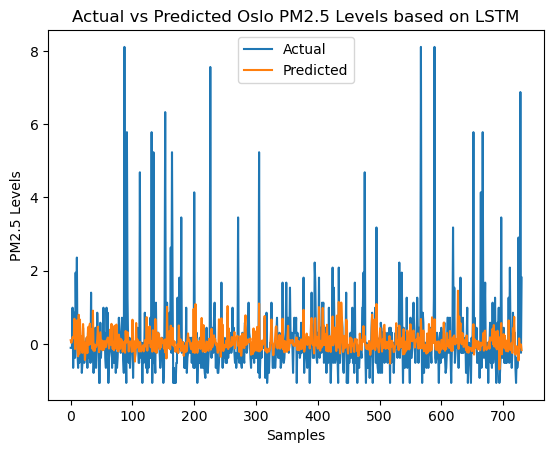

In [9]:
# Plot predicted vs. actual values
y_pred = final_model.predict(X_test.reshape((-1, 1, X_test.shape[1])))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('PM2.5 Levels')
plt.title('Actual vs Predicted Oslo PM2.5 Levels based on LSTM')
plt.legend()
plt.show()

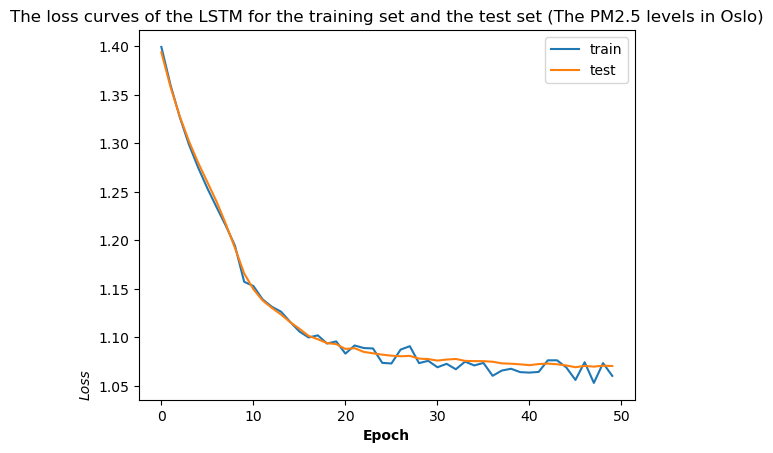

In [10]:
# 对损失进行可视化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('The loss curves of the LSTM for the training set and the test set (The PM2.5 levels in Oslo)')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', style='italic', loc='bottom')
plt.legend()
plt.show()


In [6]:
import sys
print(sys.version)


3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
